# Post Number

## Analysis

In [13]:
%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [14]:
# Analytical Tools
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.stats.api as sms

# General Utilities
import math
import json
import pprint
import itertools
import importlib

# Custom Utilities
import utilities.processing as processing
import utilities.plotting as plotting
import utilities.describe as describe

# Some settings
from IPython.display import Markdown, display
log = pprint.pprint
space = lambda: print()
printmd = lambda text: display(Markdown(text))
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Reading Data and Defining Constants

In [15]:
FILE_NAMES = [
    'raw-data/post-number-data.json'
]

NUM_QUESTIONS, NUM_JUDGEMENTS = 10, 2
GROUP_SIZE = NUM_QUESTIONS // 2

ALL_LABELS = processing.get_all_labels(NUM_QUESTIONS)
LOW_LABELS, HIGH_LABELS = ALL_LABELS[:GROUP_SIZE], ALL_LABELS[GROUP_SIZE:]
JUDGMENT_LABELS = processing.get_judgment_labels(NUM_JUDGEMENTS)

with open(FILE_NAMES[0]) as file:
    master_responses = [json.loads(line) for line in file if line]

### Reading Responses into Data
Creates a `DataFrame` based on the survey data.

In [16]:
col_labels = processing.get_col_labels(NUM_QUESTIONS,
                                       NUM_JUDGEMENTS)
data = {label: [] for label in col_labels}

In [17]:
processing.fill_experiment_data(data, master_responses)
master_responses[0]['data'][3]

{'control': False,
 'internal_node_id': '0.0-3.0-0.0',
 'judgmentIndicies': [0, 1],
 'questionIndicies': [14, 20, 25, 46, 35, 44, 30, 0, 4, 33],
 'questionScores': [2399, 27, 23, 30, 2395, 27, 2435, 31, 2413, 2398],
 'responses': '{"Q0":"3","Q1":"3"}',
 'rt': 4786,
 'time_elapsed': 18528,
 'trial_index': 3,
 'trial_type': 'survey-likert'}

In [18]:
data = pd.DataFrame(data)
data = data[data.consent == 1]
sample_size = len(data)
print(data.size, sample_size)
data.head()

1640 40


,consent,high_q0_index,high_q0_j0,high_q0_j1,high_q0_score,high_q1_index,high_q1_j0,high_q1_j1,high_q1_score,high_q2_index,...,low_q2_j1,low_q2_score,low_q3_index,low_q3_j0,low_q3_j1,low_q3_score,low_q4_index,low_q4_j0,low_q4_j1,low_q4_score
0,1,14,3,3,2399,35,3,3,2395,30,...,3,30,44,3,4,27,0,3,3,31
1,1,17,3,3,2398,31,2,2,2396,9,...,0,30,28,1,3,-4,49,2,2,25
2,1,43,2,4,2417,12,4,1,2410,8,...,0,24,30,4,1,26,9,0,0,21
3,1,13,6,5,2408,3,6,4,2400,27,...,2,27,31,1,2,35,1,6,6,29
4,1,29,2,1,2390,10,2,2,2403,17,...,3,48,23,2,1,18,16,1,2,21


### Examining Participants Without Variance

New we consider elimating participants with little to no variance to determine if this had any noticable effect on our results. For example, particpant number two in our study had a variance of 0.2, meaning nearly ever response he or she gave was 3; we remove all such particpants and test for significance in the same way.

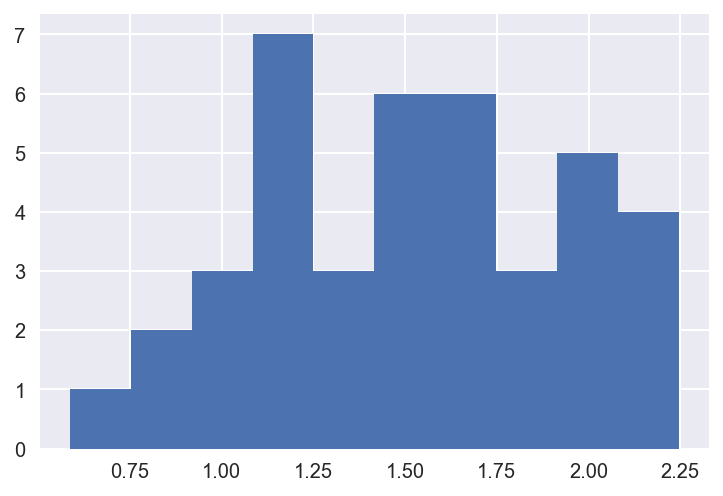

In [19]:
all_judgment_headers = ['{}_{}'.format(q_label, j_label) for 
                        q_label, j_label in itertools.product(
                            ALL_LABELS, JUDGMENT_LABELS)]
data['total_var'] = data[all_judgment_headers].std(axis=1)
plt.hist(data['total_var'])
plt.show()

# problematic = data[data.total_var < 0.75]
# problematic_judgments = problematic[all_judgment_headers]
# for index, row in problematic_judgments.iterrows():
#      print(np.unique(row))

In [20]:
data = data[data.total_var > 0.75]
print('{} eliminated'.format(sample_size - len(data)))

1 eliminated


### Simple T-Tests
We first attempt to replicate the results of the first experiment by once again conducting a paired samples t-test.

In [21]:
# Update the table with intermediate values
low_means, low_err = [], []
high_means, high_err = [], []
sample_size = len(data)

for j_label in JUDGMENT_LABELS:
    low_headers = ['{}_{}'.format(q_label, j_label) for q_label in LOW_LABELS]
    high_headers = ['{}_{}'.format(q_label, j_label) for q_label in HIGH_LABELS]
    low_data = data[low_headers].mean(axis=1)
    high_data = data[high_headers].mean(axis=1)
    
    data['{}_low'.format(j_label)] = low_data
    data['{}_high'.format(j_label)] = high_data
    data['{}_diff'.format(j_label)] = high_data - low_data
    
    low_means.append(low_data.mean())
    low_err.append(low_data.std() / math.sqrt(sample_size))
    high_means.append(high_data.mean())
    high_err.append(high_data.std() / math.sqrt(sample_size))

In [22]:
JUDGMENT_LABELS

['j0', 'j1']

Curiosity: t = -0.705, p = 0.485 (1 greater)
Popularity: t = 0.746, p = 0.46 (0 greater)


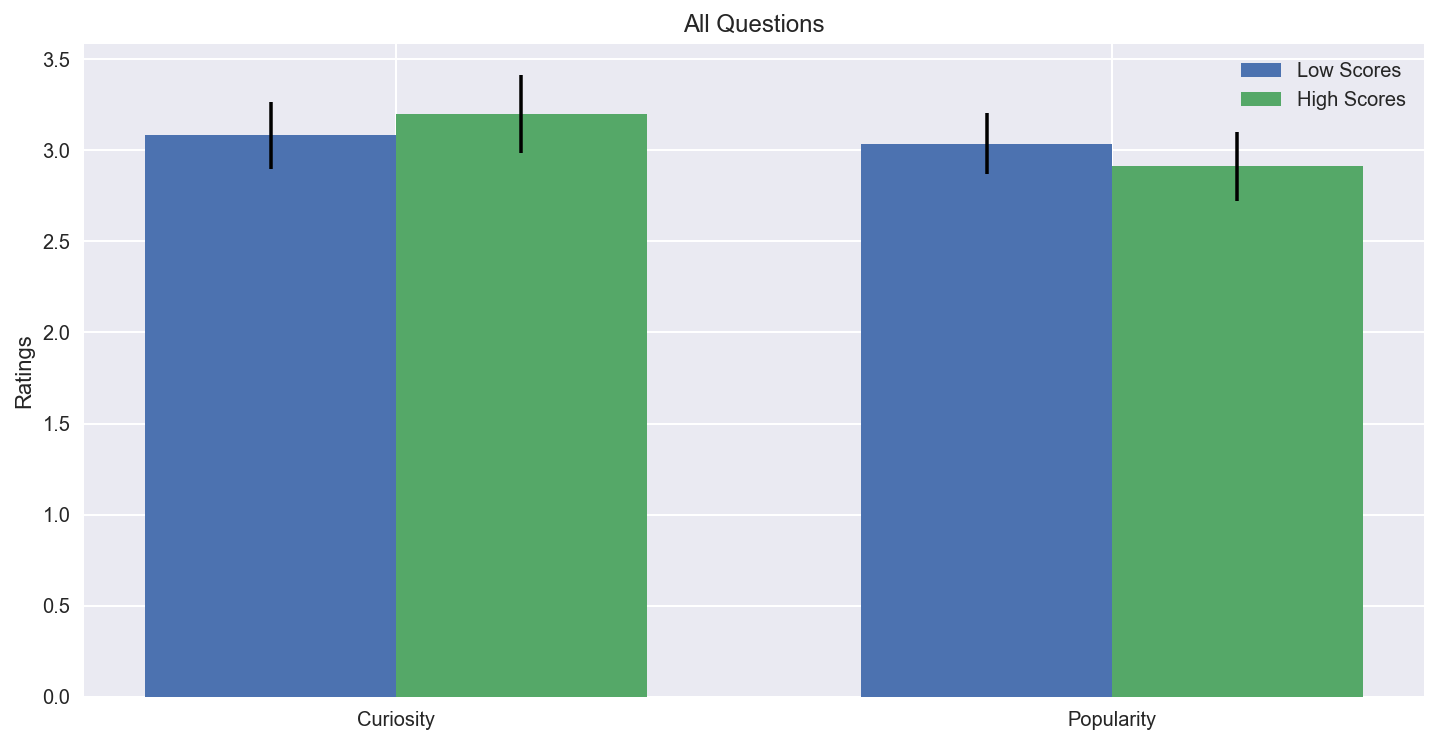

In [23]:
# Compute averages, run t-test and plot
PLOTTING_OPTIONS = {
    'y_label': 'Ratings',
    'ticks': ['Curiosity', 'Popularity'],
    'legend': ['Low Scores', 'High Scores'],
    'title': 'All Questions',
    'size': (12, 6)
}

for index, j_label in enumerate(JUDGMENT_LABELS):
    low_data = data['{}_low'.format(j_label)]
    high_data = data['{}_high'.format(j_label)]
    print('{}: {}'.format(PLOTTING_OPTIONS['ticks'][index],
              describe.paired_t_test(low_data, high_data)))

plotting.plot_double_bar(low_means, low_err, high_means,
                         high_err, **PLOTTING_OPTIONS)


### Mediation Analysis

In [32]:
# Aggreate all questions and choice
columns = ['group', 'curiosity', 'popularity']
flattened_data = {col: [] for col in columns}

for index, row in data.iterrows():
    for q_label in ALL_LABELS:
        level = 1 if row['{}_score'.format(q_label)] > 240.9 else 0
        flattened_data[columns[0]].append(level)
        flattened_data[columns[1]].append(row['{}_j0'.format(q_label)])
        flattened_data[columns[2]].append(row['{}_j1'.format(q_label)])

In [33]:
new_data = pd.DataFrame(flattened_data)
print(new_data.size, len(new_data))
new_data.head()

1170 390


,curiosity,group,popularity
0,2.0,0,1.0
1,3.0,0,3.0
2,1.0,0,0.0
3,1.0,0,3.0
4,2.0,0,2.0


In [35]:
# Views 
y = new_data['curiosity']
X = new_data['popularity']
X = sm.add_constant(X)

linear_model = sm.OLS(y, X)
results = linear_model.fit()
predictions = results.predict(X)
display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              curiosity   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     181.4
Date:                Fri, 23 Mar 2018   Prob (F-statistic):           3.48e-34
Time:                        11:56:53   Log-Likelihood:                -730.22
No. Observations:                 390   AIC:                             1464.
Df Residuals:                     388   BIC:                             1472.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2642      0.161      7.869      0.000       0.948       1.580
popularity     0.6310      0.047     13.467      0.000       0.539       0.723
==============================================================================
Omnibus:                        0.826   Durbin-Watson:                   1.624
Prob(Omnibus):                  0.662   Jarque-Bera (JB):                0.934
Skew:                          -0.079   Prob(JB):                        0.627
Kurtosis:                       2.819   Cond. No.                         7.34
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
sample_size

39

### Upvote Comparison

In [37]:
upvote_data = pd.read_pickle('raw-data/exp_two_responses.pkl')
upvote_data.head()

,consent,high_q0_choice,high_q0_index,high_q0_j0,high_q0_j1,high_q0_j2,high_q0_j3,high_q0_j4,high_q0_j5,high_q0_j6,...,j4_high,j4_diff,j5_low,j5_high,j5_diff,j6_low,j6_high,j6_diff,low_choice,high_choice
0,1,1,38,3,3,2,1,3,4,2,...,2.4,-0.2,3.4,3.2,-0.2,1.8,3.0,1.2,0.4,0.6
2,1,1,31,4,1,3,3,5,2,2,...,3.8,1.0,2.6,3.2,0.6,2.6,3.0,0.4,0.6,0.4
3,1,0,41,4,4,1,4,4,3,2,...,3.4,0.6,2.0,2.8,0.8,3.4,2.0,-1.4,0.8,0.2
4,1,1,37,3,3,4,4,3,1,2,...,2.2,0.0,2.0,2.8,0.8,2.8,3.0,0.2,0.4,0.6
5,1,1,16,4,4,5,5,4,6,5,...,3.8,0.2,4.2,3.8,-0.4,3.8,4.2,0.4,0.4,0.6


In [41]:
number_curiosity_difference = data['j0_diff']
upvotes_curiosity_difference = upvote_data['j0_diff']

In [44]:
print(
    describe.independent_t_test(
        number_curiosity_difference,
        upvotes_curiousity_difference
    )
)

t = -1.72, p = 0.0867 (1 greater)
